### Application of SMOTE to the Datset

This notebook is ran AFTER Context Encoder and BEFORE Classifier. 

This applies SMOTE to the tensor files outputted by the CNNBiLSTM and BERT. It gets the data from the pickle files in /embed/ folder. 

### Importing of libraries

In [125]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch, os, pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from model import DATASET_PATH, FCClassifier
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import classification_report
from graph_context_dataset import FeatureEngineeredDataset
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
dataset_path = DATASET_PATH 

In [153]:
train_file_paths = [
    "embed/" + dataset_path + "/u_prime_CNNBiLSTM_train.pkl",
    "embed/" + dataset_path + "/u_prime_BERT_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_DGCN_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_edgeAttr_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv2_edgeAttr_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_RGAT_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_EGAT_train.pkl",
]

test_file_paths = [
    "embed/" + dataset_path + "/u_prime_CNNBiLSTM_test.pkl",
    "embed/" + dataset_path + "/u_prime_BERT_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_DGCN_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_edgeAttr_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv2_edgeAttr_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_RGAT_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_EGAT_test.pkl",
]

val_file_paths = [
    "embed/" + dataset_path + "/u_prime_CNNBiLSTM_dev.pkl",
    "embed/" + dataset_path + "/u_prime_BERT_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_DGCN_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_edgeAttr_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv2_edgeAttr_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_RGAT_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_EGAT_dev.pkl",
]

train_features_file_output = [
    'embed/' + dataset_path + '/u_prime_CNNBiLSTM_train_BorderSmoteTomek.pkl',
    "embed/" + dataset_path + "/u_prime_BERT_train_BorderSmoteTomek.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_DGCN_train_BorderSmoteTomek.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_train_BorderSmoteTomek.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_edgeAttrtrain_BorderSmoteTomek.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv2_edgeAttr_train_BorderSmoteTomek.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_RGAT_train_BorderSmoteTomek.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_EGAT_train_BorderSmoteTomek.pkl",
]
# its all the same
train_labels_file_output = [
    'embed/' + dataset_path + '/u_prime_CNNBiLSTM_train_BorderSmoteTomek_Labels.pkl',
    "embed/" + dataset_path + "/u_prime_BERT_train_BorderSmoteTomek_Labels.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_DGCN_train_BorderSmoteTomek_Labels.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_train_BorderSmoteTomek_Labels.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_edgeAttr_train_BorderSmoteTomek_Labels.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv2_edgeAttr_train_BorderSmoteTomek_Labels.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_RGAT_train_BorderSmoteTomek_Labels.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_EGAT_train_BorderSmoteTomek_Labels.pkl",
]
dictKey = {
    0 : 'cnnbilstm',
    1 : 'bert',
    2 : 'bert-dgcn',
    3 : 'bert-gatv1',
    4 : 'bert-gatv1-edgeAttr',
    5 : 'bert-gatv2-edgeAttr',
    6 : 'bert-rgat',
    7 : 'bert-egat',
    }
selected_indices = [0,1,5,6,7]

### Get Train, Test, and Dev Data

In [44]:
# df = pd.read_csv('data\DatasetPreparation\X_train.csv', encoding='shift_jis')

# # Print the column names
# print(df.columns)

# columns_to_use = df.columns[1:]


In [15]:
# # Read the CSV file
# X_train = pd.read_csv('data\DatasetPreparation\X_train.csv', encoding='shift_jis', usecols=columns_to_use)
# X_test = pd.read_csv('data\DatasetPreparation\X_test.csv', encoding='shift_jis', usecols=columns_to_use)
# X_dev = pd.read_csv('data\DatasetPreparation\X_dev.csv', encoding='shift_jis', usecols=columns_to_use)

# y_train = pd.read_csv('data\DatasetPreparation\y_train.csv', encoding='shift_jis')
# y_test = pd.read_csv('data\DatasetPreparation\y_test.csv', encoding='shift_jis')
# y_dev = pd.read_csv('data\DatasetPreparation\y_dev.csv', encoding='shift_jis')

# # Display the first three rows
# print(X_train.shape)
# print(y_train.shape)

# print(X_test.shape)
# print(y_test.shape)

# print(X_dev.shape)
# print(y_dev.shape)

In [17]:
# X_train = pd.read_csv('data/' + dataset_path + '/train_sent_emo_dya.csv', encoding='shift_jis')
# X_test = pd.read_csv('data/' + dataset_path+ '/test_sent_emo_dya.csv', encoding='utf-8')
# X_dev = pd.read_csv('data/' + dataset_path + '/dev_sent_emo_dya.csv', encoding='utf-8')

file_path = "data/dump/" + dataset_path + "/labels_train.pkl"
with open(file_path, 'rb') as file:
    y_train = pickle.load(file)
y_train = torch.tensor(y_train)

file_path = "data/dump/" + dataset_path + "/labels_test.pkl"
with open(file_path, 'rb') as file:
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

file_path = "data/dump/" + dataset_path + "/labels_dev.pkl"
with open(file_path, 'rb') as file:
    y_val = pickle.load(file)
y_dev = torch.tensor(y_val)

In [18]:
# X_train.head(10)

### Get Emotion Labels

In [166]:
file_path = "data/dump/" + dataset_path + "/labels_train.pkl"
with open(file_path, 'rb') as file:
    y_train = pickle.load(file)
y_train = torch.tensor(y_train)

file_path = "data/dump/" + dataset_path + "/labels_test.pkl"
with open(file_path, 'rb') as file:
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

file_path = "data/dump/" + dataset_path + "/labels_dev.pkl"
with open(file_path, 'rb') as file:
    y_val = pickle.load(file)
y_val = torch.tensor(y_val)
    
file_path = 'data/dump/' + dataset_path + '/label_decoder.pkl'
with open(file_path, 'rb') as file:
    label_decoder = pickle.load(file)

### Borderline-SMOTE + TOMEK Links

In [68]:
def apply_borderline_smote_tomek(context_flat_np, labels):
    """
    Applies Borderline-SMOTE followed by TOMEK Links to the provided context tensor.
    
    Args:
    - context_flat_np (np.ndarray): Flattened context data.
    - labels (np.ndarray): Corresponding labels for the data.
    
    Returns:
    - np.ndarray: The resampled context data.
    - np.ndarray: The resampled labels.
    """
    # Apply Borderline-SMOTE
    smote = BorderlineSMOTE(random_state=42)
    context_resampled, labels_resampled = smote.fit_resample(context_flat_np, labels)
    
    # Apply Tomek Links
    tomek = TomekLinks()
    context_resampled, labels_resampled = tomek.fit_resample(context_resampled, labels_resampled)
    
    return context_resampled, labels_resampled


### Apply to CNNBiLSTM

Function to apply Borderline-SMOTE + TOMEK Links to the dataset

In [69]:
def convert_cnn_bilstm_output(cnn_bilstm_output):
    """
    Converts CNNBiLSTM output to be compatible with Borderline-SMOTE with TOMEK Links.
    
    Args:
    - cnn_bilstm_output (torch.Tensor): Output from CNNBiLSTM.
    
    Returns:
    - np.ndarray: Flattened output as numpy array.
    """
    original_shape = cnn_bilstm_output.shape
#     print(original_shape)
    if len(original_shape) > 2:
        output_flat = cnn_bilstm_output.view(original_shape[0], -1).detach().numpy()
    else:
        output_flat = cnn_bilstm_output.detach().numpy()
    
    return output_flat

Export resampled file and its labels

In [37]:
# with open('embed/' + dataset_path + '/u_prime_CNNBiLSTM_train_BorderSmoteTomek.pkl', 'wb') as f:
#     pickle.dump(cnn_bilstm_resampled, f)

# with open('embed/' + dataset_path + '/u_prime_CNNBiLSTM_train_BorderSmoteTomek_Labels.pkl', 'wb') as f:
#     pickle.dump(cnn_bilstm_labels_resampled, f)

### Apply to BERT

In [147]:
def convert_bert_output(bert_output):
    """
    Converts BERT output to be compatible with Borderline-SMOTE with TOMEK Links.
    
    Args:
    - bert_output (list of torch.Tensor): Output from BERT.
    
    Returns:
    - np.ndarray: Flattened output as numpy array.
    """
    # Convert each tensor in the list to a numpy array and concatenate them
    output_flat_list = [tensor.detach().numpy() for tensor in bert_output]
    output_flat = np.concatenate(output_flat_list, axis=0)
    
    return output_flat


### Apply SMOTE to selected Train features

In [167]:
checkFile = os.path.isfile(train_features_file_output[0])
if checkFile:
    for i in selected_indices:
        with open(train_file_paths[i], 'rb') as file:
            train_feature = pickle.load(file)
            print("Currently at ", dictKey[i])
            if i == 0: 
                concatenated_tensor = torch.cat(train_feature, dim=0)
                reshaped_tensor = concatenated_tensor.view(-1, 200)
                output_flat = convert_cnn_bilstm_output(reshaped_tensor)
                output_resampled, labels_resampled = apply_borderline_smote_tomek(output_flat, y_train)
                print(f"cnn_bilstm_resampled shape: {output_resampled.shape}")
            else:
                output_flat = convert_bert_output(train_feature)
                output_resampled, labels_resampled = apply_borderline_smote_tomek(output_flat, y_train)
                print(f"bert_resampled shape: {output_resampled.shape}")

        with open(train_features_file_output[i], 'wb') as f:
            pickle.dump(output_resampled, f)

        with open(train_labels_file_output[i], 'wb') as f:
            pickle.dump(labels_resampled, f)

Currently at  cnnbilstm
cnn_bilstm_resampled shape: (41590, 200)
Currently at  bert
bert_resampled shape: (41653, 768)
Currently at  bert-gatv2-edgeAttr
bert_resampled shape: (41571, 512)
Currently at  bert-rgat
bert_resampled shape: (41461, 80)
Currently at  bert-egat
bert_resampled shape: (41196, 512)


### Perform Classification on test data without Tuning

#### Preparing the dataset

In [105]:
def is_three_dimensional(tensor):
    return tensor.dim() == 3

def concatenate_tensors(tensor_list):
    return torch.cat(tensor_list, dim=0)

def import_features(file_paths):
    featuresList = []
    attList = []
    for file_path in file_paths:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if isinstance(data, list):
                print(type(data), " instance of list: ", len(data))
                data =  torch.cat(data, dim=0)
                
                if is_three_dimensional(data):
                    data = data.squeeze(1)
                featuresList.append(data)
            else:
                print(type(data), " instance of tensor, ", data.shape)
                featuresList.append(data)
                
    return featuresList

In [171]:
os.makedirs("data/dump/" + dataset_path + "/SMOTE_data_for_classifier", exist_ok=True)
file_path1 = "data/dump/" + dataset_path + "/SMOTE_data_for_classifier/trainList.pkl"
file_path2 = "data/dump/" + dataset_path + "/SMOTE_data_for_classifier/testList.pkl"
file_path3 = "data/dump/" + dataset_path + "/SMOTE_data_for_classifier/valList.pkl"

checkFile1 = os.path.isfile(file_path1)
checkFile2 = os.path.isfile(file_path2)
checkFile3 = os.path.isfile(file_path3)

if checkFile1 and checkFile2 and checkFile3: 
    with open(file_path1, "rb") as file:
        trainList = pickle.load(file)
    with open(file_path2, "rb") as file:
        testList = pickle.load(file)
    with open(file_path3, "rb") as file:
        valList = pickle.load(file)
else:
    selected_train_paths = [train_features_file_output[i] for i in selected_indices]
    selected_test_paths = [test_file_paths[i] for i in selected_indices]
    selected_val_paths = [val_file_paths[i] for i in selected_indices]

    trainList = import_features(selected_train_paths)
    testList = import_features(selected_test_paths)
    valList = import_features(selected_val_paths)
    
    with open(file_path1, 'wb') as file:
        pickle.dump(trainList, file)
    with open(file_path2, 'wb') as file:
        pickle.dump(testList, file)
    with open(file_path3, 'wb') as file:
        pickle.dump(valList, file)

<class 'numpy.ndarray'>  instance of tensor,  (41590, 200)
<class 'numpy.ndarray'>  instance of tensor,  (41653, 768)
<class 'numpy.ndarray'>  instance of tensor,  (41571, 512)
<class 'numpy.ndarray'>  instance of tensor,  (41461, 80)
<class 'numpy.ndarray'>  instance of tensor,  (41196, 512)
<class 'list'>  instance of list:  577
<class 'list'>  instance of list:  577
<class 'list'>  instance of list:  577
<class 'list'>  instance of list:  577
<class 'list'>  instance of list:  577
<class 'list'>  instance of list:  270
<class 'list'>  instance of list:  270
<class 'list'>  instance of list:  270
<class 'list'>  instance of list:  270
<class 'list'>  instance of list:  270


In [177]:
def to_tensor(data):
    if isinstance(data, torch.Tensor):
        return data
    elif isinstance(data, np.ndarray):
        return torch.tensor(data)
    else:
        raise TypeError(f"Unsupported data type: {type(data)}")
        
def model_train2(X_set=None, Y_set=None, num_epochs=30, loss_difference_threshold=0.001, 
                 hidden_dims=128, dropout_rate=0.35, lr=0.0001, 
                 optimizer_class=torch.optim.Adam, criterion_class=torch.nn.CrossEntropyLoss, 
                 nodalAtt=None, umask=None, seq_len=None, no_cuda=True, batch_size=16):
    
    output_dim = 7  # Number of classes
    input_dim = X_set.shape[1] if len(X_set) > 0 else 0
    model = FCClassifier(input_dim, hidden_dims, output_dim, dropout_rate)
    criterion = criterion_class()
    optimizer = optimizer_class(model.parameters(), lr=lr)
    loss_history = []
    accuracy_history = []
    previous_loss = float('inf')

    epoch_num = num_epochs

    # Create DataLoader
    dataset = TensorDataset(X_set.clone(), Y_set.clone())
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        correct_predictions = 0
        total_instances = 0
        
        with tqdm(total=len(data_loader), desc=f'Epoch {epoch+1}/{num_epochs}', leave=False) as pbar:
            for inputs, labels in data_loader:
                optimizer.zero_grad()
                
                # Assuming sequence length and umask are handled appropriately here
                # Adjust the following lines based on your actual implementation
                outputs = model(inputs.float(), nodalAtt, seq_len, umask)
                log_prob = torch.log_softmax(outputs, dim=1)
                loss = criterion(log_prob, labels)
                
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                _, predicted = torch.max(log_prob, dim=1)
                correct_predictions += (predicted == labels).sum().item()
                total_instances += labels.size(0)
                pbar.update(1)
        
        epoch_loss = total_loss / total_instances
        epoch_accuracy = correct_predictions / total_instances
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)
        
        if epoch > 0:
            loss_diff = abs(epoch_loss - previous_loss)
            if loss_diff < loss_difference_threshold:
                print(f"Training stopped early at epoch {epoch+1}.")
                print(f"Loss difference ({loss_diff}) is below the threshold ({loss_difference_threshold}).")
                epoch_num = epoch + 1
                break
        
        previous_loss = epoch_loss
    
    return model, epoch_num

In [183]:
def classify_emotions(model=None, X_set=None, Y_set=None, typeSet=None, 
                      isSimpleFC=False, i_dict=None,
                      nodalAtt=None, umask=None, seq_len=None, no_cuda=True, batch_size=32):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Initialize empty lists and dictionaries to store predictions and true labels
    all_predictions = []
    all_labels = []
    f1_scores_per_class = {}

    # Create DataLoader
    dataset = TensorDataset(X_set, Y_set)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.float()
            labels = labels.long()
            
            device = 'cuda' if torch.cuda.is_available() and not no_cuda else 'cpu'
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Assume seq_len and umask are given for each batch if they are not None
            if seq_len is not None:
                last_idx = seq_len[i][0]
            if umask is not None:
                umask_slice = umask[i][0][:last_idx].unsqueeze(0)
            else:
                umask_slice = None

            outputs = model(inputs, nodalAtt, seq_len, umask_slice)

            outputs = outputs.squeeze()
            labels = labels.squeeze()

            log_prob = F.log_softmax(outputs, 1)

            _, predicted = torch.max(log_prob, 1)

            # Append the predictions and labels to the lists
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate the classification report
    report = classification_report(all_labels, all_predictions, target_names=label_decoder.values(), output_dict=True, zero_division=0)

    # Calculate the required metrics
    accuracy = report['accuracy']
    recall = report['weighted avg']['recall']
    weighted_f1 = report['weighted avg']['f1-score']
    f1_micro = report.get('micro avg', {}).get('f1-score', accuracy)
    f1_macro = report.get('macro avg', {}).get('f1-score', 0.0) 
    
    # Extract F1 scores per class
    for emotion, metrics in report.items():
        if emotion in label_decoder.values():  # Check if it's an emotion class
            f1_scores_per_class[emotion] = metrics['f1-score']

    if typeSet == "validation":
        print("Classified: ", dictKey[i_dict])
    
    return {
        'model_name': dictKey[i_dict],
        'typeSet': typeSet,
        'isSimpleFC': isSimpleFC,
        'accuracy': accuracy,
        'recall': recall,
        'weighted_f1': weighted_f1,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_scores_per_class': f1_scores_per_class
    }

In [178]:
file_path = "data/dump/" + dataset_path + "/labels_test.pkl"
with open(file_path, 'rb') as file:
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

file_path = "data/dump/" + dataset_path + "/labels_dev.pkl"
with open(file_path, 'rb') as file:
    y_val = pickle.load(file)
y_val = torch.tensor(y_val)

In [179]:
def get_smote_labels(file_path):
    with open(file_path, "rb") as file:
        y_train = pickle.load(file)
        
    return y_train

In [176]:
trainList[0].shape

(41590, 200)

In [210]:
dataset = FeatureEngineeredDataset(trainList, testList, valList)
dataLoader = DataLoader(dataset, batch_size=1, shuffle=False)

os.makedirs("data/dump/" + dataset_path + "/SMOTE_data_for_classifier/results", exist_ok=True)
file_path1 = "data/dump/" + dataset_path + "/SMOTE_data_for_classifier/results/classifier_test_no_tuning_Df.pkl"
file_path2 = "data/dump/" + dataset_path + "/SMOTE_data_for_classifier/results/performance_per_emotion_no_tuning_Df.pkl"

checkFile = os.path.isfile(file_path1)

if not checkFile: 
    with open(file_path1, "rb") as file:
        df_results_sorted = pickle.load(file)
    with open(file_path2, "rb") as file:
        df_f1_scores_per_class = pickle.load(file)
else:
    results = []
    num_epochs = 40
    i = 0
    for trainSet, testSet, valSet in dataLoader:
        selected_i = selected_indices[i]
        y_train = get_smote_labels(train_labels_file_output[selected_i])
        
        # Handle trainSet, testSet, valSet based on their types
        if isinstance(trainSet, list):
            trainSet = trainSet[0].squeeze(0)
            testSet = testSet[0].squeeze(0)
            valSet = valSet[0].squeeze(0)
        else:
            trainSet = trainSet.squeeze(0)
            testSet = testSet.squeeze(0)
            valSet = valSet.squeeze(0)

        X_train_tensor = to_tensor(trainSet)
        Y_train_tensor = to_tensor(y_train)

        print("Currently at", dictKey[i])
        print("X train shape: ", X_train_tensor.shape)
        print("y train shape: ", Y_train_tensor.shape)
        
        model, _ = model_train2(X_set=X_train_tensor, Y_set=Y_train_tensor, num_epochs=num_epochs)
        
        X_test_tensor = to_tensor(testSet)
        Y_test_tensor = to_tensor(y_test)
        print("X test shape: ", X_test_tensor.shape)
        print("y test shape: ", Y_test_tensor.shape)
        
        result = classify_emotions(model=model, X_set=X_test_tensor, Y_set=Y_test_tensor, typeSet='test', 
                                   isSimpleFC=True, i_dict=i)
        results.append(result)

        i += 1

    # Prepare data for classifier results DataFrame
    classifier_results = []
    f1_scores_per_class_results = []

    for i, result in enumerate(results):
        f1_scores, accuracy, recall, weighted_f1, f1_micro, f1_macro = result
        classifier_result = {
            'model_name': dictKey[selected_indices[i]],
            'typeSet': 'test',
            'isSimpleFC': True,
            'accuracy': accuracy,
            'recall': recall,
            'weighted_f1': weighted_f1,
            'f1_micro': f1_micro,
            'f1_macro': f1_macro
        }
        classifier_results.append(classifier_result)
        
        f1_scores_row = {'model_name': dictKey[selected_indices[i]]}
        f1_scores_row.update(f1_scores)
        f1_scores_row['weighted_f1'] = weighted_f1
        f1_scores_per_class_results.append(f1_scores_row)

    # Create DataFrame for classifier results
    columns_classifier = ['model_name', 'typeSet', 'isSimpleFC', 'accuracy', 'recall', 'weighted_f1', 'f1_micro', 'f1_macro']
    df_results = pd.DataFrame(classifier_results, columns=columns_classifier)
    df_results_sorted = df_results.sort_values(by='weighted_f1', ascending=False)

    with open(file_path1, 'wb') as file:
        pickle.dump(df_results_sorted, file)
        
    # Create DataFrame for performance per emotion with model_name and f1_scores
    emotion_columns = list(f1_scores.keys()) + ['weighted_f1']
    columns_per_class = ['model_name'] + emotion_columns
    df_f1_scores_per_class = pd.DataFrame(f1_scores_per_class_results, columns=columns_per_class)

    with open(file_path2, 'wb') as file:
        pickle.dump(df_f1_scores_per_class, file)


Currently at cnnbilstm
X train shape:  torch.Size([41590, 200])
y train shape:  torch.Size([41590])


Training stopped early at epoch 2.
Loss difference (0.0004699733687811569) is below the threshold (0.001).
X test shape:  torch.Size([3400, 200])
y test shape:  torch.Size([3400])
Currently at bert
X train shape:  torch.Size([41653, 768])
y train shape:  torch.Size([41653])


Training stopped early at epoch 19.
Loss difference (0.0009610575754364983) is below the threshold (0.001).
X test shape:  torch.Size([3400, 768])
y test shape:  torch.Size([3400])
Currently at bert-dgcn
X train shape:  torch.Size([41571, 512])
y train shape:  torch.Size([41571])


Training stopped early at epoch 22.
Loss difference (0.0007999392209715322) is below the threshold (0.001).
X test shape:  torch.Size([3400, 512])
y test shape:  torch.Size([3400])
Currently at bert-gatv1
X train shape:  torch.Size([41461, 80])
y train shape:  torch.Size([41461])


Training stopped early at epoch 14.
Loss difference (0.0008650852573443835) is below the threshold (0.001).
X test shape:  torch.Size([3400, 80])
y test shape:  torch.Size([3400])
Currently at bert-gatv1-edgeAttr
X train shape:  torch.Size([41196, 512])
y train shape:  torch.Size([41196])


Training stopped early at epoch 19.
Loss difference (0.0009155630123465902) is below the threshold (0.001).
X test shape:  torch.Size([3400, 512])
y test shape:  torch.Size([3400])


In [211]:
selected_indices

[0, 1, 5, 6, 7]

In [212]:
df_f1_scores_per_class

,model_name,anger,disgust,fear,joy,neutral,sadness,surprise,weighted_f1
0,cnnbilstm,0.015296,0.045064,0.035860,0.000000,0.000000,0.000000,0.166284,0.021482
1,bert,0.416222,0.245283,0.160000,0.500448,0.715690,0.292174,0.469767,0.557181
2,bert-gatv2-edgeAttr,0.292347,0.066667,0.049383,0.326087,0.371125,0.181215,0.195734,0.305221
3,bert-rgat,0.172566,0.050934,0.037383,0.175515,0.316742,0.102439,0.203024,0.233281
4,bert-egat,0.374877,0.098280,0.131687,0.395393,0.521845,0.260090,0.390295,0.428045


In [213]:
df_results_sorted

,model_name,typeSet,isSimpleFC,accuracy,recall,weighted_f1,f1_micro,f1_macro
1,bert,test,True,0.545294,0.545294,0.557181,0.545294,0.399941
4,bert-egat,test,True,0.397059,0.397059,0.428045,0.397059,0.310353
2,bert-gatv2-edgeAttr,test,True,0.278235,0.278235,0.305221,0.278235,0.211794
3,bert-rgat,test,True,0.196471,0.196471,0.233281,0.196471,0.151229
0,cnnbilstm,test,True,0.056471,0.056471,0.021482,0.056471,0.037501


In [140]:
y_train_tmp[:10]

array([4, 4, 4, 4, 6, 4, 4, 4, 4, 4], dtype=int64)

### Perform Tuning on top 2 results

### Visualizations - These take long

In [20]:
def visualize_bert_output(bert_output, labels):
    """
    Visualizes the BERT output with the corresponding emotion labels using PCA and t-SNE.
    
    Args:
    - bert_output (np.ndarray or list of torch.Tensor): Output from BERT.
    - labels (list or np.ndarray): Emotion labels for the BERT output.
    - label_decoder (dict): Dictionary to decode labels from integers to emotion names.
    """
    # Check if bert_output is a list of torch tensors or numpy array
    if isinstance(bert_output, list) and isinstance(bert_output[0], torch.Tensor):
        bert_output_flat = np.concatenate([tensor.detach().numpy() for tensor in bert_output], axis=0)
    else:
        bert_output_flat = bert_output

    # Perform PCA
    pca = PCA(n_components=2)
    output_pca = pca.fit_transform(bert_output_flat)
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    output_tsne = tsne.fit_transform(bert_output_flat)
    
    unique_labels = np.unique(labels)

    # Plot PCA and t-SNE results with color-coded labels
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        plt.scatter(output_pca[indices, 0], output_pca[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('PCA of BERT Output with Color-Coded Labels')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2, position=[0.65, 0.1, 0.35, 0.8])
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        plt.scatter(output_tsne[indices, 0], output_tsne[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('t-SNE of BERT Output with Color-Coded Labels')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

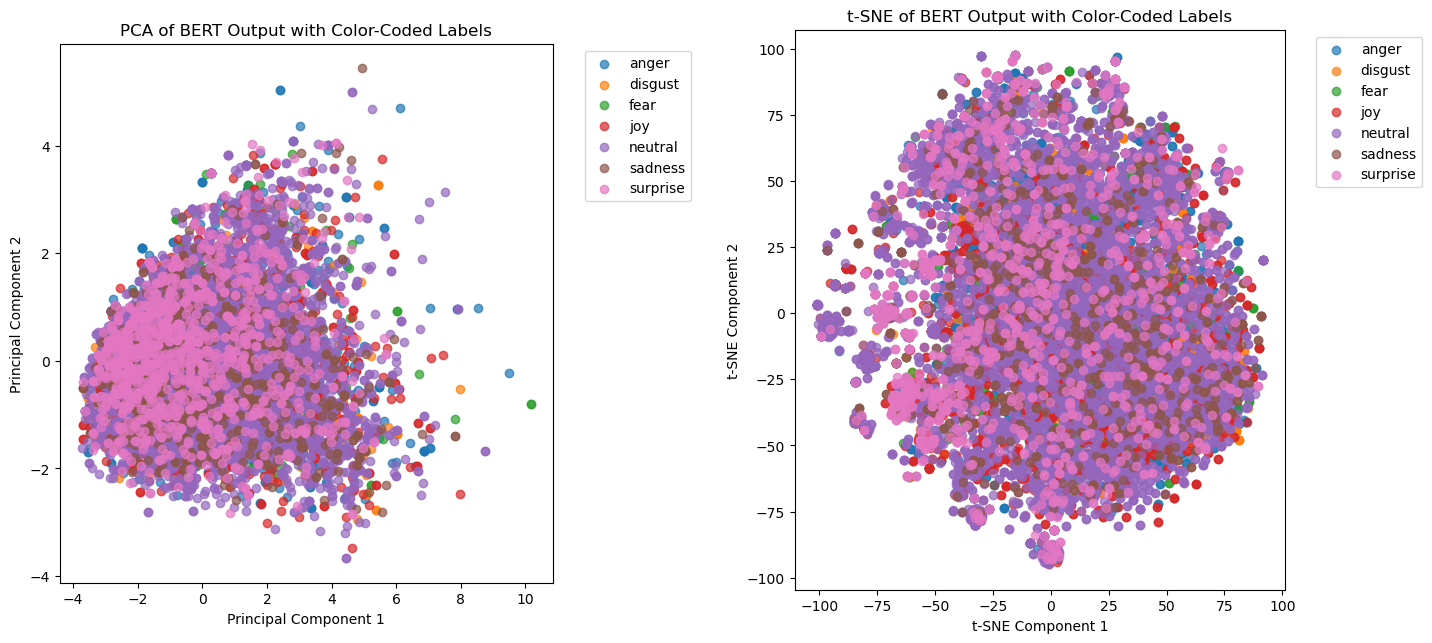

In [21]:
visualize_bert_output(bert_output, y_train['Emotion'])

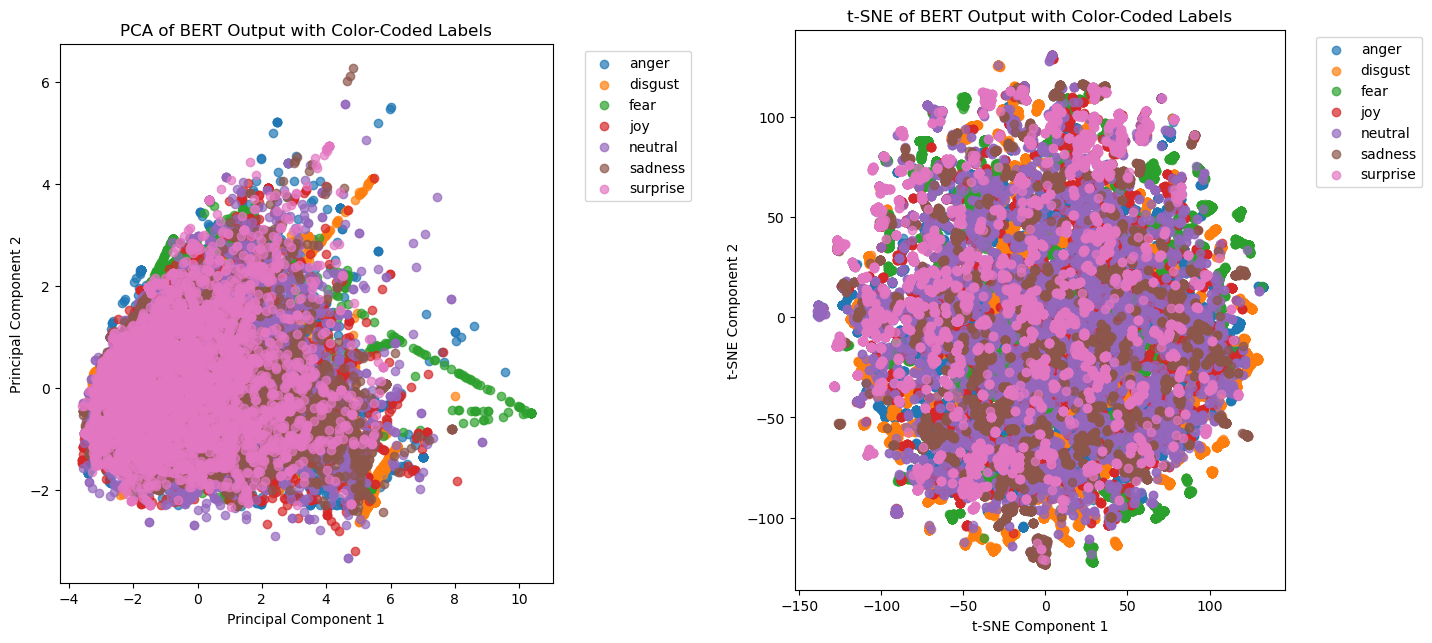

In [22]:
visualize_bert_output(bert_resampled, bert_labels_resampled)

In [23]:
def visualize_cnn_bilstm_output(cnn_bilstm_output, labels):
    """
    Visualizes the CNNBiLSTM output with the corresponding emotion labels using PCA and t-SNE.
    
    Args:
    - cnn_bilstm_output (np.ndarray or torch.Tensor): Output from CNNBiLSTM.
    - labels (list or np.ndarray): Emotion labels for the CNNBiLSTM output.
    - label_decoder (dict): Dictionary to decode labels from integers to emotion names.
    """
    # Check if cnn_bilstm_output is a numpy array or torch tensor
    if isinstance(cnn_bilstm_output, torch.Tensor):
        cnn_bilstm_output_flat = cnn_bilstm_output.view(cnn_bilstm_output.shape[0], -1).detach().numpy()
    else:
        cnn_bilstm_output_flat = cnn_bilstm_output

    # Perform PCA
    pca = PCA(n_components=2)
    output_pca = pca.fit_transform(cnn_bilstm_output_flat)
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    output_tsne = tsne.fit_transform(cnn_bilstm_output_flat)
    
    unique_labels = np.unique(labels)

    # Plot PCA and t-SNE results with color-coded labels
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        plt.scatter(output_pca[indices, 0], output_pca[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('PCA of CNNBiLSTM Output with Color-Coded Labels')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2, position=[0.65, 0.1, 0.35, 0.8])
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        plt.scatter(output_tsne[indices, 0], output_tsne[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('t-SNE of CNNBiLSTM Output with Color-Coded Labels')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()


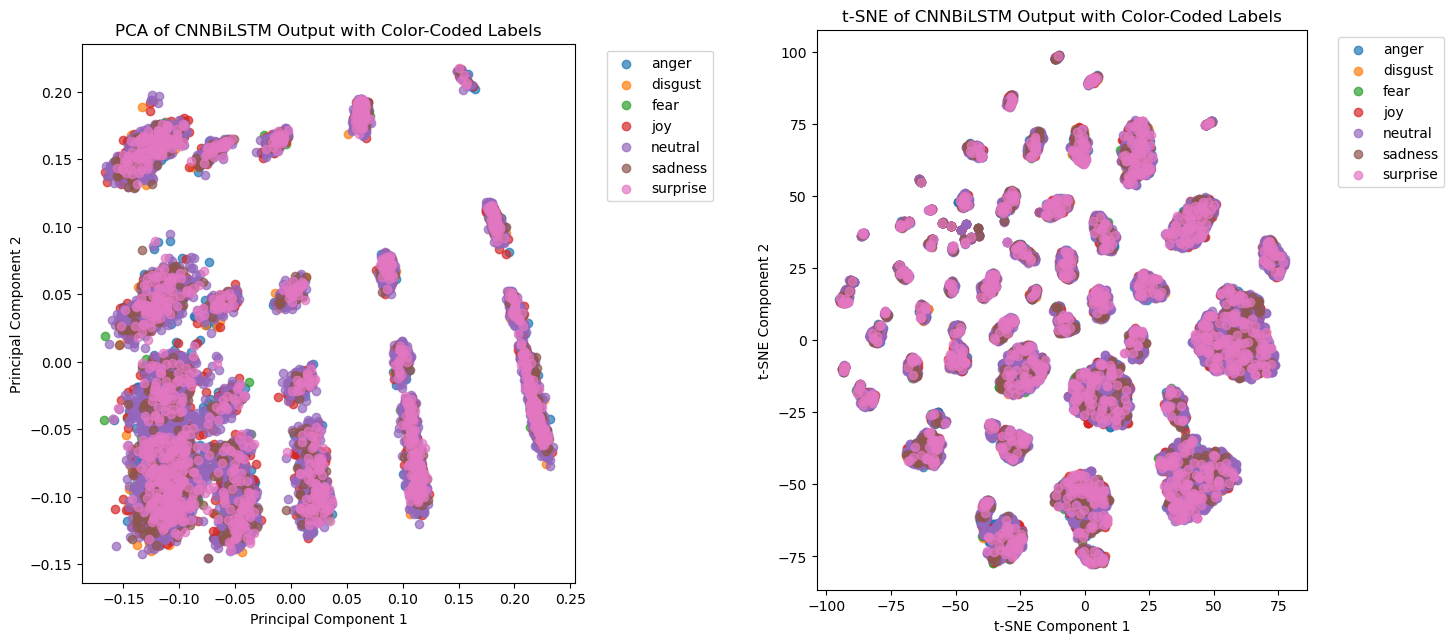

In [24]:
visualize_cnn_bilstm_output(cnn_bilstm_output, y_train['Emotion'])

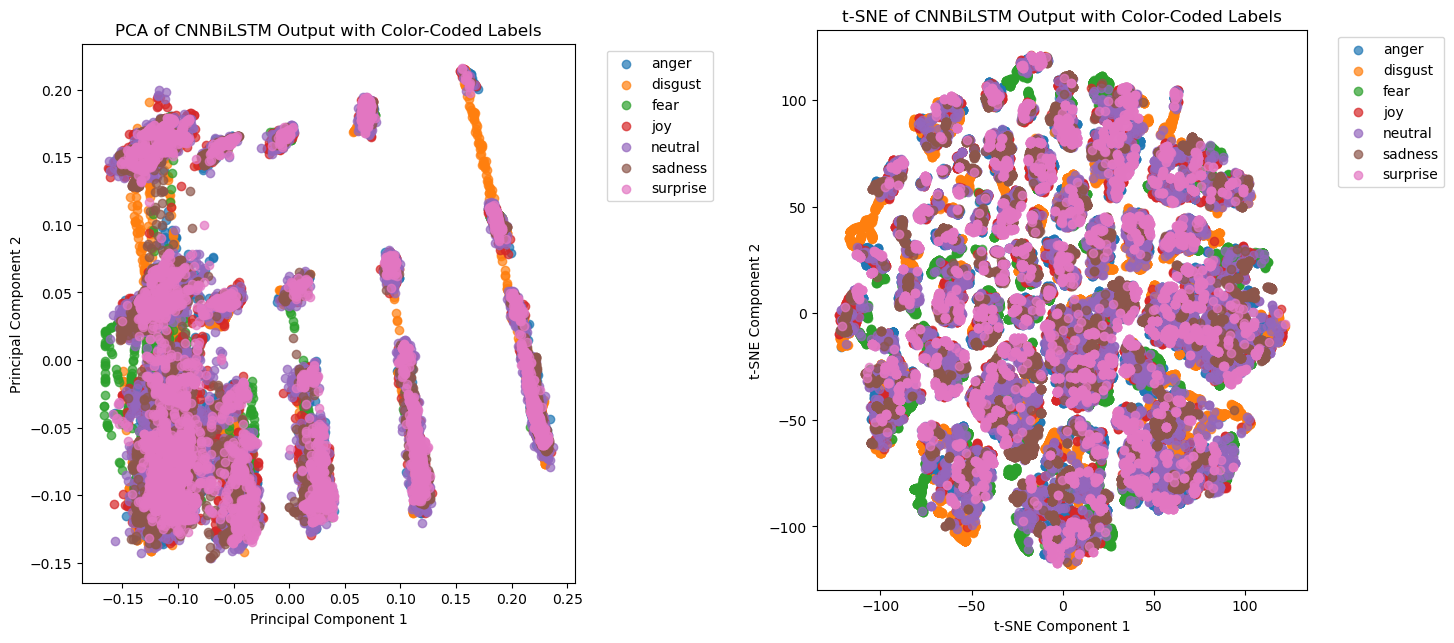

In [25]:
visualize_cnn_bilstm_output(cnn_bilstm_resampled, cnn_bilstm_labels_resampled) 